In [30]:
import sys

# resolve path for notebook
sys.path.append('../')

In [31]:
import gym
import math
import torch
import pyglet
import random
import minihack

import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

from nle import nethack
from collections import deque

from torch.autograd import Variable
from torch.distributions import Categorical

from environments.QuestEnvironment import QuestEnvironment

In [32]:
# if there is a Cuda GPU, then we want to use it
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [33]:
num_episodes = 1000
max_steps = 5000
alpha = 0.001
alpha = 0.00001
gamma = 0.9999
epsilon = 1e-12
epsilon = 1e-1
OBS_SPACE = 'glyphs_crop'
#OBS_SPACE = 'blstats'
seed = 99
verbose = True
print_action_messages = False
intermediate_plots = False

In [34]:
env = QuestEnvironment().create(
    reward_lose = -100,
    reward_win = 100,
    penalty_step = -0.1,
    penalty_time = -0.001,
    max_episode_steps = max_steps,
    seed = seed
)

In [35]:
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
env.seed(seed)

(99, 625960368137152567, False)

In [36]:
class PolicyValueNetwork:

    def __init__(self, env, alpha):

        if len(env.observation_space.spaces[OBS_SPACE].shape) == 1:
            self.obs_space = env.observation_space.spaces[OBS_SPACE].shape[0]
        else:
            self.obs_space = env.observation_space.spaces[OBS_SPACE].shape[0] * \
                        env.observation_space.spaces[OBS_SPACE].shape[1]

        self.policy_net = torch.nn.Sequential(
            torch.nn.Linear(self.obs_space, self.obs_space*2),
            torch.nn.ReLU(),

            # hidden layers
            torch.nn.Linear(self.obs_space*2, self.obs_space*2),
            torch.nn.ReLU(),

            torch.nn.Linear(self.obs_space*2, env.action_space.n),
            torch.nn.Softmax(dim = -1)
        )

        self.policy_optimizer = torch.optim.Adam(self.policy_net.parameters(), lr = alpha)

        self.value_net = torch.nn.Sequential(
            torch.nn.Linear(self.obs_space, self.obs_space*2),
            torch.nn.ReLU(),

            # hidden layers
            torch.nn.Linear(self.obs_space*2, self.obs_space*2),
            torch.nn.ReLU(),

            torch.nn.Linear(self.obs_space*2, self.obs_space),
            torch.nn.ReLU(),
            torch.nn.Linear(self.obs_space, 1)
        )

        self.value_optimizer = torch.optim.Adam(self.value_net.parameters(), lr = alpha)


nn = PolicyValueNetwork(env, alpha)

In [37]:
visit_counts = dict()
coord_rewards = dict()

def get_exploration_reward(state, reward):
    s = state['blstats']

    #return reward
    coords = (int(s[0]), int(s[1]))

    if coords not in visit_counts:
        visit_counts[coords] = 1
        #return 0.001
        coord_rewards[coords] = reward
    else:
        #return 0
        visit_counts[coords] += 1
        coord_rewards[coords] += reward

    return -0.001 * visit_counts[coords]

    r = 0
    r += coord_rewards[coords] / visit_counts[coords]
    r += 0.01 * math.sqrt( \
        (math.log(visit_counts[coords])) \
        / \
        visit_counts[coords])

    return r

In [38]:
def convert_observation(obs):
    obs = obs[OBS_SPACE]
    obs = torch.tensor(obs, dtype=torch.float)  
    obs = torch.flatten(obs)
    obs = torch.reshape(obs, (1, obs.shape[0]))
    obs = torch.nn.functional.normalize(obs, p=2.0, dim=1, eps=epsilon, out=None)
    return obs

In [39]:
action_text = [
    'EAST', 'NORTH', 'SOUTH', 'WEST', 
    #'UP', 
    'DOWN', 
    #'OPEN', 
    #'MOVE',
    'EAT',
    'PICKUP',
    'ZAP', 
    'APPLY'
    ]

In [40]:

# training
subproblem_counts = np.zeros(4)
save_video = False
previous_description = ''
messages_received = dict()
actions_taken = dict()

TotalRewards = []
TotalLoss = []
Total_Rewards = []

for k in range(num_episodes):

    episode_reward = 0
    episode_loss = 0

    obs = env.reset(save_video)

    save_video = False
    
    done = False
    Actions, States, Rewards = [], [], []

    for h in range(max_steps):

        message = obs['message']
        msg = bytes(message)
        msg = str(msg).replace("'", "").replace('"', '').lstrip("b").rstrip("\\x00").rstrip("\x00")

        if msg not in messages_received:
            messages_received[msg] = 1
        else:
            messages_received[msg] += 1

        obs = convert_observation(obs)

        probs = nn.policy_net(obs)
        dist = torch.distributions.Categorical(probs = probs)
        action = dist.sample().item()

        obs_, rew, done, info = env.step(action)

        stats = obs_['blstats']
        coords = (stats[0], stats[1])

        if coords == (27, 11):
            subproblem_counts[0] += 1

        if action_text[action] not in actions_taken:
            actions_taken[action_text[action]] = 1
        else:
            actions_taken[action_text[action]] += 1

        if verbose:
            #print( f"\rEpisode: {k+1}, Step: {h+1}, Coords: {coords}, Reward: {rew:0.4f}, Action: {action_text[action]}  
            print( f"\rEpisode: {k+1}, Steps: {h+1}        ", end="")

        rew = rew + get_exploration_reward(obs_, rew)

        if rew > 5:
            save_video = True
        
        #env.render()

        episode_reward += rew

        Actions.append(torch.tensor(action, dtype=torch.int))
        States.append(obs)
        Rewards.append(rew)

        # move to the next state
        obs = obs_

        if done:
            break


    TotalRewards.append(episode_reward)

    DiscountedReturns = []
    r = 0
    # discount over the trajectory
    for step in reversed(range(len(Rewards))):
        r = Rewards[step] + gamma * r
        DiscountedReturns.insert(0, r)

    # normalize the returns?
    # ensure type 
    DiscountedReturns = np.array(DiscountedReturns)

    # calculate the mean and std
    mean = DiscountedReturns.mean(axis = 0)
    std = DiscountedReturns.std(axis = 0)

    # average and normalize the returns
    if std != 0.0:
        DiscountedReturns = (DiscountedReturns - mean) / std

    PolicyLoss = []
    ValueLoss = []
    Total_Loss = []

    sum_loss = 0
    
    for State, Action, G in zip(States, Actions, DiscountedReturns):

        value = nn.value_net(State)

        delta = G - value

        probs = nn.policy_net(State)
        policy_dist = torch.distributions.Categorical(probs = probs)
        log_probs = policy_dist.log_prob(Action)

        policy_loss = -( delta.detach() * log_probs )
        nn.policy_optimizer.zero_grad()
        policy_loss.backward()
        nn.policy_optimizer.step()

        pl = policy_loss.detach().numpy()
        PolicyLoss.append(pl)

        value_loss = torch.sum(delta**2) / 2
        nn.value_optimizer.zero_grad()
        value_loss.backward()
        nn.value_optimizer.step()

        vl = value_loss.detach().numpy()
        ValueLoss.append(vl)
        
        # probs = nn(State)
        # dist = torch.distributions.Categorical(probs=probs)    
        # log_prob = dist.log_prob(Action)
        
        # loss = -(log_prob*G)
        total_loss = pl + vl
        sum_loss += total_loss[0]
        Total_Loss.append(total_loss)
        
        # optim.zero_grad()
        # loss.backward()
        # optim.step()

    TotalLoss.append(sum_loss)

    if verbose:
        print( f"""
            Tot. Rewards: {np.sum(Rewards):0.4f}, Avg. Reward: {np.mean(Rewards):0.4f}, 
            Tot. Loss: {np.sum(Total_Loss):0.4f}, Avg Loss: {np.mean(Total_Loss):0.4f},
            Tot. Policy Loss: {np.sum(PolicyLoss):0.4f}, Avg Policy Loss: {np.mean(PolicyLoss):0.4f},
            Tot. Value Loss: {np.sum(ValueLoss):0.4f}, Avg Value Loss: {np.mean(ValueLoss):0.4f}
            """)

    if print_action_messages:

        print("\nActions Taken:")
        for key, val in actions_taken.items():
            print(f"- {key}: {val}")

        print("\nMessages Received:")
        for key, val in messages_received.items():
            print(f"- {key}: {val}")

    if intermediate_plots:

        PolicyLoss = np.reshape(PolicyLoss, (np.shape(PolicyLoss)[0], 1))
        ValueLoss = np.reshape(ValueLoss, (np.shape(ValueLoss)[0], 1))
        Total_Loss = np.reshape(Total_Loss, (np.shape(Total_Loss)[0], 1))

        #Plot stuff
        window = int(max_steps * 0.01)
        fig, axs = plt.subplots(3, 2)
        fig.set_figheight(6)
        fig.set_figwidth(8)

        #axs[0].plot(pd.DataFrame(Rewards))

        axs[0][0].title.set_text('Reward')
        #axs[0][0].set_xlabel('episodes')
        axs[0][0].set_ylabel('reward')
        axs[0][0].plot(pd.DataFrame(Rewards))
        axs[0][0].plot(pd.DataFrame(Rewards).rolling(window).mean())
        axs[0][0].grid(True)

        axs[0][1].title.set_text('Total Loss')
        #axs[0][1].set_xlabel('episodes')
        axs[0][1].set_ylabel('loss')
        axs[0][1].plot(pd.DataFrame(Total_Loss))
        axs[0][1].plot(pd.DataFrame(Total_Loss).rolling(window).mean())
        axs[0][1].grid(True)

        axs[1][0].title.set_text('Policy Loss')
        axs[1][0].set_xlabel('episodes')
        axs[1][0].set_ylabel('loss')
        axs[1][0].plot(pd.DataFrame(PolicyLoss))
        axs[1][0].plot(pd.DataFrame(PolicyLoss).rolling(window).mean())
        axs[1][0].grid(True)

        axs[1][1].title.set_text('Value Loss')
        axs[1][1].set_xlabel('episodes')
        axs[1][1].set_ylabel('loss')
        axs[1][1].plot(pd.DataFrame(ValueLoss))
        axs[1][1].plot(pd.DataFrame(ValueLoss).rolling(window).mean())
        axs[1][1].grid(True)

        fig.tight_layout()

        plt.show()

Episode: 1, Step: 4872        
            Tot. Rewards: -632.7099, Avg. Reward: -0.1299, 
            Tot. Loss: -1258.1343, Avg Loss: -0.2582,
            Tot. Policy Loss: -1841.7325, Avg Policy Loss: -0.3780,
            Tot. Value Loss: 583.5984, Avg Value Loss: 0.1198
            
Episode: 2, Step: 4674        
            Tot. Rewards: -768.7098, Avg. Reward: -0.1645, 
            Tot. Loss: -725.9155, Avg Loss: -0.1553,
            Tot. Policy Loss: -2278.4785, Avg Policy Loss: -0.4875,
            Tot. Value Loss: 1552.5632, Avg Value Loss: 0.3322
            
Episode: 3, Step: 4578        
            Tot. Rewards: -848.3601, Avg. Reward: -0.1853, 
            Tot. Loss: -536.6662, Avg Loss: -0.1172,
            Tot. Policy Loss: -1777.4241, Avg Policy Loss: -0.3883,
            Tot. Value Loss: 1240.7579, Avg Value Loss: 0.2710
            
Episode: 4, Step: 4771        
            Tot. Rewards: -1556.0366, Avg. Reward: -0.3261, 
            Tot. Loss: -387.5236, Avg Loss: 

KeyboardInterrupt: 

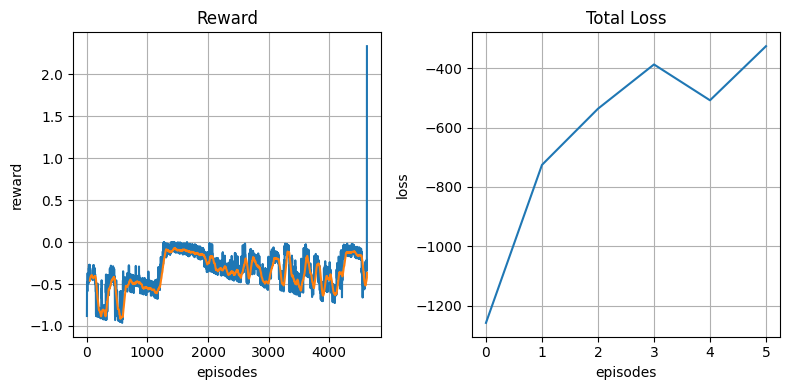

In [51]:
window = int(max_steps * 0.01)
fig, axs = plt.subplots(1, 2)
fig.set_figheight(4)
fig.set_figwidth(8)

#axs[0].plot(pd.DataFrame(Rewards))

axs[0].title.set_text('Total Reward')
axs[0].set_xlabel('episodes')
axs[0].set_ylabel('reward')
axs[0].plot(pd.DataFrame(Rewards))
axs[0].plot(pd.DataFrame(Rewards).rolling(window).mean())
axs[0].grid(True)

axs[1].title.set_text('Total Loss')
axs[1].set_xlabel('episodes')
axs[1].set_ylabel('loss')
axs[1].plot(pd.DataFrame(TotalLoss))
axs[1].plot(pd.DataFrame(TotalLoss).rolling(window).mean())
axs[1].grid(True)

fig.tight_layout()

plt.show()

In [ ]:
fig = plt.figure(figsize = (10, 5))
subtasks = ["Maze Exit","Crossed lava river","Defeated Demon","Staircase"]
# creating the bar plot
plt.bar(subtasks, subproblem_counts, color ='maroon',
        width = 0.4)
plt.ylim(0, 100)
plt.xlabel("Sub tasks")
plt.ylabel("Times Completed")
plt.title("Number of Times Subtasks have been completed per 100 episodes")
plt.show()